In [3]:
import numpy as np
from numpy import array as A
from matplotlib.pyplot import subplots
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.animation import FuncAnimation
from numpy.linalg import norm
import matplotlib.pyplot as plt
from tqdm import tqdm
import flightTools as ft
from collections import deque
from keras.optimizers import Adam
from keras import Sequential
from keras.layers import Dense
import random

In [4]:
class Rocket:

    def __init__(self):
        """
        Holds all the constant attributes of the rocket
        Units for each quantity are in the square brackets
        """
        self.hull_mass = 1000                            # Mass of the rocket w/o fuel [kg]
        self.fuel_mass = 5000                            # Initial mass of the fuel only [kg]
        self.width = 2                                   # Width [m]
        self.height = 20                                 # Height [m]
        self.impact_velocity = 5.0                       # Speed above which rocket crashes on impact [m/s]
        self.exhaust_velocity = 200 * 9.81               # Specific impulse of all rocket's engines [s]
        self.main_thrust = 100000                        # Maximum thrust of main engine [N]
        self.side_thrust = 50000                         # Maximum thrust of side engines [N]

In [5]:
class Flight:

    def __init__(self, flight_controller=None, verbose=True):
        """
        Keeps track of the data and runs the simulation for a single flight
        """
                
        # Initialise the rocket
        self.rocket = Rocket()
        
        #  Simulation settings
        self.simulation_resolution = 0.1
        self.max_runtime = 30.0
        self.gravitational_field = A([0.0, -9.81])
        self.verbose = verbose
        self.sim_scale = 5 * self.rocket.height
        self.base_size = 10.0

        # Initial conditions
        # (all of these arrays will be appended to as the simulation runs)
        self.status = A([0]).astype('int')
        self.time = A([0.0])
        self.score = A([0.0])
        
        # Assign a random starting position
        self.position = A([[np.random.uniform(- self.sim_scale / 2 + 5 * self.rocket.width,
                                              self.sim_scale / 2 - 5 * self.rocket.width),
                            np.random.uniform(self.sim_scale / 2,                        
                            self.sim_scale - self.rocket.height)]])

        # Assign a random starting velocity
        self.velocity = A([[np.random.uniform(-10.0, 10.0), np.random.uniform(-10.0, 10.0)]])
        
        self.acceleration = A([self.gravitational_field])
        self.mass = A([self.rocket.hull_mass +
                       self.rocket.fuel_mass])
        self.throttle = A([0])
        
        # Check the flight controller function
        if callable(flight_controller):
            self.flight_controller = flight_controller
        else:
            self.flight_controller = ft.template_controller

    def run(self):
        """
        Runs the simulation given this flight's initial conditions
        and flight controller
        """

        # Get the initital state vector
        state = A([self.position[0][0], self.position[0][1], 
                   self.velocity[0][0], self.velocity[0][1]])
        
        i, done = 1, False
        # Start at time step 1 and run until max_runtime or the rocket lands/crashes
        while (not done) and (self.time[i - 1] < self.max_runtime):

            # Get the throttle position
            throttle = self.flight_controller(A([state]))

            # If rocket is out of fuel, cut the throttle
            if self.mass[i - 1] <= self.rocket.hull_mass:
                throttle = 0

            # Update the flight based on the throttle chosen by the controller
            state, reward, done, _ = self.update(throttle)
      
            # Print the current status
            if self.verbose:
                update_text = 'T: {:05.2f} | {:<6}'.format(self.time[i - 1] + self.simulation_resolution,
                                                           self.status_string())
                print('\r', update_text, end='')

            # Iterate
            i += 1

    def update(self, throttle):
        """
        Updates the position, velocity and mass of the rocket at each
        timestep, given the previous state and the current throttle setting
        """

        # Set some numbers for convenience
        dt = self.simulation_resolution
        ve = self.rocket.exhaust_velocity

        # Convert throttle selection to vector: ([M, L, R])
        M, L, R = thrust_parse(throttle)
        delta_m_M = (M * self.rocket.main_thrust * dt) / ve
        delta_m_L = (L * self.rocket.side_thrust * dt) / ve
        delta_m_R = (R * self.rocket.side_thrust * dt) / ve

        # Update the total mass
        self.mass = np.append(self.mass, [self.mass[-1] - (delta_m_M + delta_m_L + delta_m_R)])

        # Update the throttle
        self.throttle = np.append(self.throttle, [throttle])

        # Update the acceleration based on the mass expulsion above
        # Note this calculation always uses the initial mass of the rocket
        # so the engine achieves the same acceleration regardless of how much fuel is in the rocket
        
        # Velocity components
        delta_v_M = A([0, ve]) * np.log((self.mass[0]  + delta_m_M) / (self.mass[0]))
        delta_v_L = A([ve, 0]) * np.log((self.mass[0]  + delta_m_L) / (self.mass[0]))
        delta_v_R = A([-ve, 0]) * np.log((self.mass[0]  + delta_m_R) / (self.mass[0]))
        
        # Total vel.
        total_a = ((delta_v_M + delta_v_L + delta_v_R) / dt) + self.gravitational_field
        self.acceleration = np.append(self.acceleration, [total_a], axis=0)

        # Update the velocity, position and time
        self.velocity = np.append(self.velocity, [self.velocity[-1] + total_a * dt], axis=0)
        self.position = np.append(self.position, [self.position[-1] + self.velocity[-1] * dt], axis=0)
        self.time = np.append(self.time, [self.time[-1] + dt])

        # Asssemble the state vector
        state = A([self.position[-1][0], self.position[-1][1],
                   self.velocity[-1][0], self.velocity[-1][1]]) / self.sim_scale
        
        # Calculate the reward
        reward = 0
        
        # Add points for moving closer to the surface and slowing down
        reward = (
            - 1.0 * (norm(flight.position[-1]) - norm(flight.position[-2])) / norm(flight.position[-2])
            - 0.8 * (norm(flight.velocity[-1]) - norm(flight.velocity[-2])) / norm(flight.velocity[-2])) 
        
        # Subtract some points for using the engine to encourage efficiency
        reward -= sum([thrust_parse(throttle)[i] * [0.05, 0.005, 0.005][i] for i in range(3)])
        
        # Check if rocket has landed on the base
        if ((self.position[-1][1] <= 0.0) and (np.abs(self.position[-1][0]) <= (2*self.base_size / 3)) and
            (norm(self.velocity[-1]) <= self.rocket.impact_velocity)):

            self.status = np.append(self.status, [1])
            self.position[-1] = A([[self.position[-1][0], 0]])
            self.velocity[-1] = A([[0.0, 0.0]])
            
            done = True
            reward = 100
        
        # Check if rocket has landed safely
        if ((self.position[-1][1] <= 0.0) and
            (norm(self.velocity[-1]) <= self.rocket.impact_velocity)):

            self.status = np.append(self.status, [1])
            self.position[-1] = A([[self.position[-1][0], 0]])
            self.velocity[-1] = A([[0.0, 0.0]])
            
            done = True
            reward = 50
            
        # Check if rocket has crashed
        elif self.position[-1][1] <= 0.0:
            self.status = np.append(self.status, [-1])
            self.position[-1] = A([[self.position[-1][0], 0]])
            self.velocity[-1] = A([[0.0, 0.0]])
            
            done = True
            reward = -50

        # Check if rocket is out of bounds
        elif ((self.position[-1][1] + self.rocket.height) > self.sim_scale or
              (np.abs(self.position[-1][0]) + self.rocket.width) > self.sim_scale / 2):
            
            self.status = np.append(self.status, [-1])
            done = True
            reward = -50
            
        # Check if rocket has gone over time
        elif (self.time[-1] > self.max_runtime):
            self.status = np.append(self.status, [0])
            done = True
            
        else:
            # Subtract some points per timestep to encourage speed
            reward -= 0.05
            self.status = np.append(self.status, [0])
            done = False
            
        # Keep track of the score
        self.score = np.append(self.score, reward)
            
        return state, reward, done, {}
            
    def status_string(self, k=-1):
        """
        Returns the current status of the rocket, given a code 0, 1 or 2
        """
        j = self.status[k]
        if j == -1:
            ss = 'Crashed'
        elif j == 0:
            ss = 'Flying'
        else:
            ss = 'Landed'
        return ss

In [6]:
def thrust_parse(j):
    """
    j in binary gives the appropriate thrust selection:
    Translation:
    Input    0 1 2 4 5 6
    Output...
    Main     0 0 0 1 1 1 2^2
    Left     0 0 1 0 0 1 2^1
    Right    0 1 0 0 1 0 2^0
    """
    if j > 2:
        k = j + 1
    else:
        k = j
    return A([x for x in '{0:03b}'.format(k)]).astype(int)

In [7]:
class FlightController:

    # This model represents the AI that the game will
    # ask for moves given some data.

    def __init__(self, state_size, action_size, weights=None):

        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.memory = deque(maxlen=20000)
        self.model = self.build_model()
        
    def build_model(self):
        
        # Construct the model below using
        # model.add(...)
        model = Sequential()
        model.add(Dense(24, input_shape=(self.state_size,), activation='tanh'))
        model.add(Dense(24, activation='tanh'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        
        return model
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def get_weights(self):

        return self.model.get_weights()

    def reset_weights(self):

        shapes = [w.shape for w in self.model.get_weights()]

        new_weights = []
        for s in shapes:

            new_weights.append(np.random.uniform(-1.0, 1.0, size=s))

        self.model.set_weights(new_weights)

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
    def __call__(self, state_vector):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            return np.argmax(self.model.predict(state_vector))
        
    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [8]:
state_size, action_size = 4, 6
fc = FlightController(state_size, action_size)

 0000/50000, Crashed , score: -54.41, e: 1.00
 0100/50000, Crashed , score: -50.30, e: 0.61
 0200/50000, Crashed , score: -56.07, e: 0.37
 0300/50000, Crashed , score: -54.47, e: 0.22
 0400/50000, Crashed , score: -51.98, e: 0.13
 0500/50000, Crashed , score: -53.40, e: 0.08
 0600/50000, Crashed , score: -54.12, e: 0.05
 0700/50000, Crashed , score: -51.93, e: 0.03
 0800/50000, Crashed , score: -52.09, e: 0.02
 0900/50000, Crashed , score: -53.53, e: 0.01
 1000/50000, Crashed , score: -52.78, e: 0.01
 1100/50000, Crashed , score: -51.87, e: 0.01
 1200/50000, Crashed , score: -49.97, e: 0.01
 1300/50000, Crashed , score: -51.22, e: 0.01
 1400/50000, Crashed , score: -51.52, e: 0.01
 1500/50000, Crashed , score: -52.73, e: 0.01
 1600/50000, Crashed , score: -52.26, e: 0.01
 1700/50000, Crashed , score: -50.89, e: 0.01
 1800/50000, Crashed , score: -51.87, e: 0.01
 1900/50000, Crashed , score: -52.18, e: 0.01
 2000/50000, Crashed , score: -50.67, e: 0.01
 2100/50000, Crashed , score: -56.

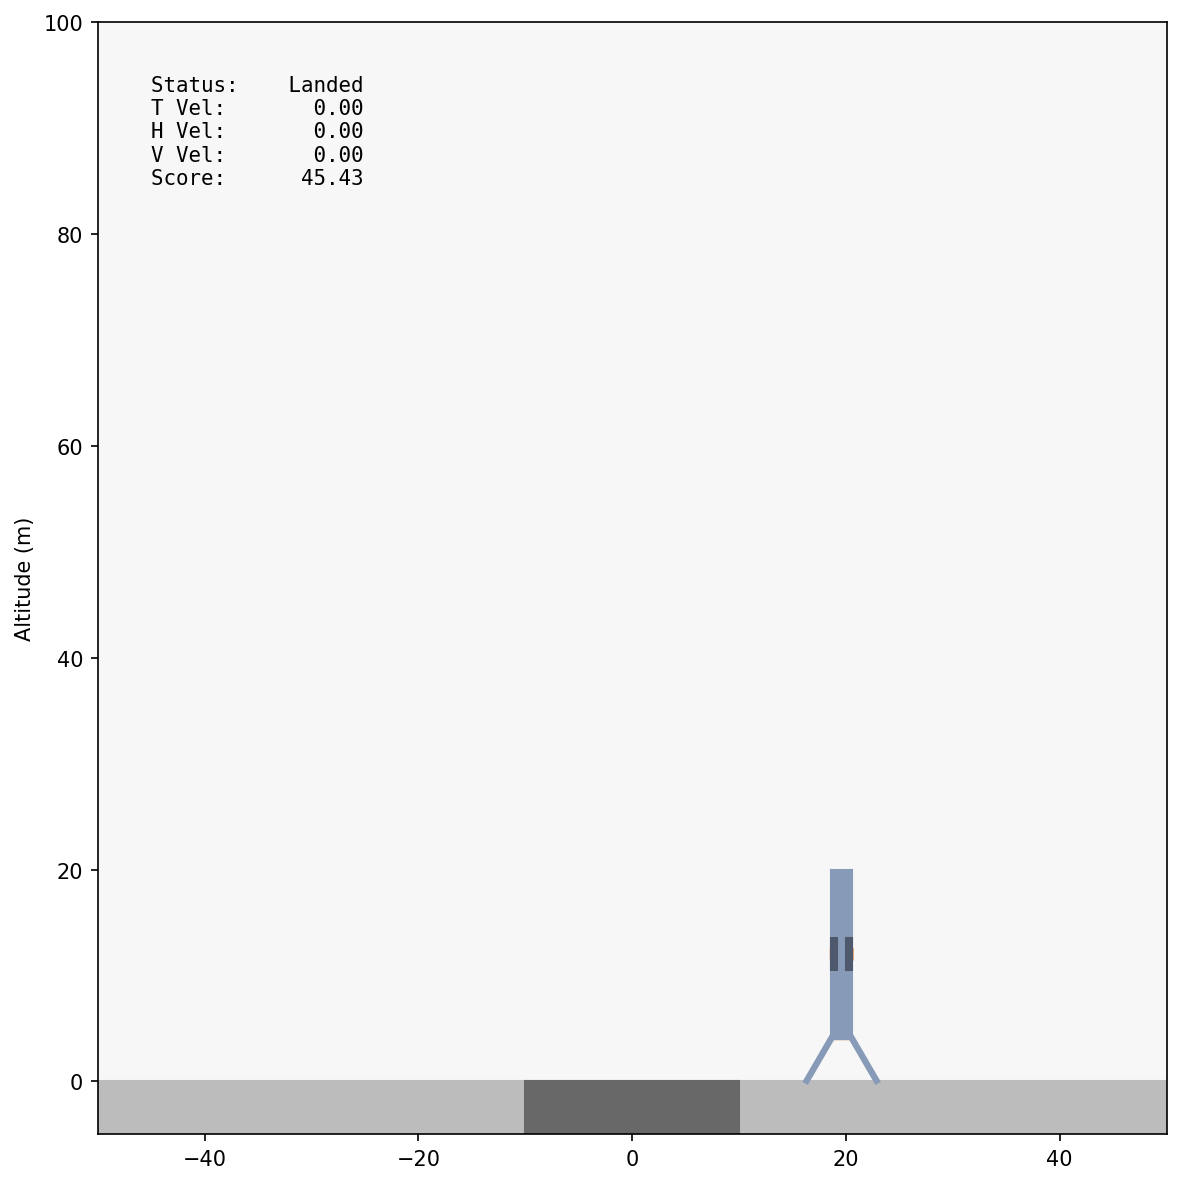

In [27]:
n_episodes = 50000
batch_size = 50

for i in range(0, n_episodes):

    flight = Flight(fc)
    
    # Get the initital state vector
    done, total_reward = False, 0
    state = A([[flight.position[0][0], flight.position[0][0],
                flight.velocity[0][1], flight.velocity[0][1]]])
    
    while not done:

        action = fc(state)
        next_state, reward, done, _ = flight.update(action)
        total_reward += reward
        
        next_state = np.reshape(next_state, [1, state_size])
        
        fc.remember(state, action, reward, next_state, done)
        state = next_state
        
        if done:
            # if flight.status[-1] == 1:
            # ft.FlightAnimation(flight, './training_plots/%04d_landing.mp4' % i)
            if i % 100 == 0:
                print("\r", "{:04d}/{:04d}, {:8s}, score: {: 03.2f}, e: {:03.2f}".format(i, n_episodes, flight.status_string(), total_reward, fc.epsilon))
                plt.close('all')
                ft.FlightAnimation(flight, './training_plots_horizontal/%04d.mp4' % i)
                fc.save('./training_weights_horizontal/weights_%04d.h5' % i)
            break

    if len(fc.memory) > batch_size:
        fc.replay(batch_size)